## 第二次讀書會-第3組

### 針對ptt數位中介服務法爭議事件，利用SnowNLP進行情緒分析。

- 課程：社群媒體分析
- 授課教授：黃三益
- 組長：B084020041劉怡謙
- 組員：B094020042黃萱妮、B084020009程尤欣、M114020052王渙鈞、姚昀誠、劉杰煊、B065040041蔡瑋駿、M114020055吳均庭

## Outline
1. About data
    - 1.1 資料基本介紹
    - 1.2 事件始末
    - 1.3 分析方向
2. CKIP標註
    - 2.1 利用CKIP進行處理
    - 2.2 探索分析 - NER
        - 2.2.1 人名(PERSON)
        - 2.2.2 組織(ORG)
        - 2.2.3 民族、宗教、政治團體(NORP)
    - 2.3 探索分析 - POS
        - 2.3.1 涉及到的名詞(Noun)
3. 利用SnowNLP進行情緒分析
    - 3.1 觀察各月份
    - 3.2 觀察特定日期


引入需要的套件

In [1]:
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image, ImageSequence

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

### CKIP
- CKIP是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起`jieba`效果更好，並且提供性命名實體辨識、詞性標註、句法分析
- github: https://github.com/ckiplab/ckiptagger

In [2]:
#gdrive-ckip # 下載ckip model
#data_utils.download_data_gdown("./") 

In [2]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

C:\Users\user\anaconda3\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
C:\Users\user\anaconda3\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
C:\Users\user\anaconda3\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


# 1. About data
#### 1.1 資料基本介紹
- 資料沿用上次讀書會所蒐集的資料
- 資料來源：文字平台收集PTT Gossip版2022-01-01 ~ 2023-03-15與《數位中介服務法》相關的文章
- 搜尋關鍵字：'數位中介'、'中介法'、'數位中介法'、'數位中介服務法'。
- 排除關鍵字：'全動'、'全動法'、'選罷法'。
- 資料時間：2022-01-01 ~ 2023-03-15 

#### 1.2 事件始末
1. 2022/06/29 國家通訊傳播委員會(NCC)提出《數位中介服務法》草案。
2. 2022/07/28 立法院資策會召開首次《數位中介服務法》公聽會，會後各界憂心該法可能對言論自由造成威脅。
3. 2022/08/18 召開《數位中介服務法》第三場公開說明會，與資訊儲存服務及線上平臺服務業者進行說明及討論。同日，PTT法務部顧問於會後受訪時表示「該法通過就跟逼我們關站並無不同」，台灣著名網路論壇與新聞網站「巴哈姆特電玩資訊站」站長也透過個人網誌表達反對《數位中介服務法》，在PTT引發大量爭議及討論。
4. 2022/08/19 NCC宣布原定2022/08/25舉辦召開的公聽會延後召開，行政院長蘇貞昌表示會在與各界溝通協商後再進行修法。

#### 1.3 分析目標
1. PTT上，針對《數位中介服務法》相關議題，八卦版友所發表意見的對象有哪些，以及其討論重點為何?
2. PTT上對《數位中介服務法》討論的情緒分布趨勢如何，正面和負面的文章主要的討論焦點、討論內容各是什麼，並使用SnowNLP情緒分析去推測文章中句子的正負情緒，結合文字雲、關鍵字找出相關討論事件。

**資訊來源**：Wikipedia及個人整理<br>

- 引入資料

In [3]:
df = pd.read_csv('./data.csv')
df = df.dropna()
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1656487267....,[新聞]NCC通過《數位中介服務法》草案臉書、YT,2022-06-29 15:21:05,YESGOTO,Gossiping,媒體來源：ETtoday新聞雲 2022年06月29日 15:07\n\n記者署名：記者陳世...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""omfg5487"", ""...",122.117.54.102,2022-06-30 01:32:56,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1656504204....,[新聞]打擊假訊息！NCC通過《數位中介服務法》,2022-06-29 20:03:22,monnom,Gossiping,1.媒體來源:\n風傳媒\n\n2.記者署名:\n林上祚\n\n3.完整新聞標題:\n打擊假...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""zwxyzxxx"", ""...",1.170.114.82,2022-06-30 01:35:14,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1656505468....,Re:[新聞]打擊假訊息！NCC通過《數位中介服務法》,2022-06-29 20:24:25,NONOTV,Gossiping,小的想起9年前 曾經有個經濟部下的單位要搞境外侵權網站封網\n\n當時引起網路各社群一片抗議...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""justice2008""...",59.104.173.247,2022-06-30 01:35:28,ptt


## 2. CKIP標註
### 2.1 利用CKIP進行處理
- 將抓取結果使用coreNLP進行自然語言處理，以下為定義文字清理的相關function

In [4]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#    paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#    print(len(paragraphs))
#    print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

CKIP設定 : 讀入自定義《數位中介服務法》辭典。

In [5]:
# 自定義辭典
with open('dict/user_dict.txt', encoding='utf-8') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(1, {'党': 500.0, '黨': 500.0}), (3, {'民進黨': 10000.0, '中介法': 10000.0, '支持者': 500.0, '好了啦': 500.0, '幹你娘': 500.0}), (4, {'言論自由': 10000.0, '主管機關': 500.0, '行政機關': 500.0, '已被刪除': 500.0, '綠色恐怖': 500.0, '500萬': 500.0, '完全執政': 500.0, '偷換概念': 500.0, '詐騙集團': 500.0}), (5, {'數位中介法': 5000.0, '中共同路人': 500.0}), (7, {'數位中介服務法': 5000.0}), (9, {'推文違反數位中介法': 500.0})]


計算實體辨識（ner）詞性標註（pos)之內容

In [8]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = []
        data_df = data_df.dropna()
        # 将float值替换为其他值（例如空字符串）
        data_df = data_df.applymap(lambda x: '' if isinstance(x, float) else x)
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [10]:
#pos_table, entity_table, sentence_table = get_nlp_result(df)

In [11]:
#儲存處理後的資料
#pos_table.to_csv('raw_data/zh/pos_table_PTT.csv', index = False)
#entity_table.to_csv('raw_data/zh/entity_table_PTT.csv', index = False)
#sentence_table.to_csv('raw_data/zh/sentence_table_PTT.csv', index = False)

讀取其處理後的結果

In [12]:
pos_table = pd.read_csv("raw_data/zh/pos_table_PTT.csv") 
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,媒體,Na
1,1,來源,Na
2,1,新聞,Na
3,1,雲年,Nd
4,1,月,Na


In [13]:
entity_table = pd.read_csv("raw_data/zh/entity_table_PTT.csv") 
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,雲年月日,DATE
1,1,陳世昌,PERSON
2,1,台北,GPE
3,1,中介服務法,LAW
4,1,日,GPE


In [14]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_PTT.csv") 
sentence_table.head()

,system_id,sentence
0,1,媒體來源新聞雲年月日
1,1,記者署名記者陳世昌台北報導
2,1,通過數位中介服務法草案臉書納管違法最高罰萬
3,1,日審議通過我國首部網路監理法令數位中介服務法草案，該草案定義網路數位
4,1,通訊傳播中介服務區分為大類，排除小規模業者之外，其他所有網路服務類型都需負擔


In [15]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1755篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1590篇有抓到ner

total posts numbers: 1755
posts have NER: 1590


## 2.2 探索分析 - NER
### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類，並以橫向長條圖呈現各實體的總數多寡。

In [16]:
entity_table['ner'].unique()

array(['DATE', 'PERSON', 'GPE', 'LAW', 'MONEY', 'ORG', 'CARDINAL', 'NORP',
       'ORDINAL', 'TIME', 'PRODUCT', 'LOC', 'FAC', 'WORK_OF_ART',
       'PERCENT', 'EVENT', 'LANGUAGE', 'QUANTITY'], dtype=object)

In [17]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
13,PERSON,5603
11,ORG,4633
4,GPE,2955
1,DATE,1636
0,CARDINAL,1087
9,NORP,533
10,ORDINAL,511
6,LAW,271


經統計後為Person(人名)最多；ORG(組織其次)；GPE則是代表地理—政治條目，比如都市，州，國家，洲等，為第三。  
而第四的DATE，推測其原因可能是當時相關討論文章中有一定數量的"新聞轉載"，根據PTT八卦版規定以[新聞]作為發文標籤時需標註新聞發布時間，故DATE在此排第四。

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


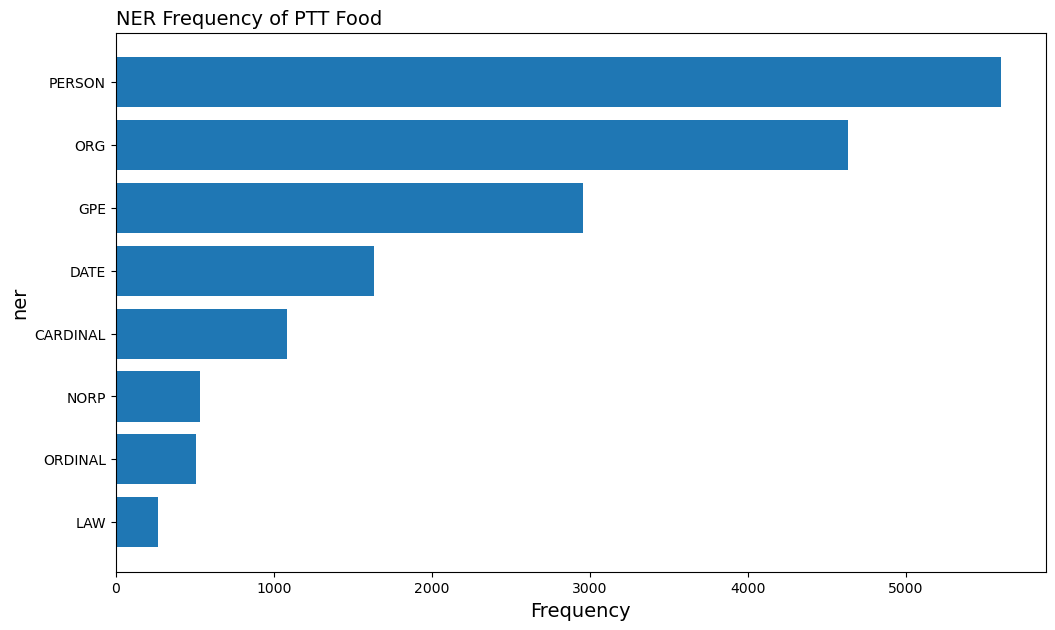

In [18]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 2.2.1 篩選、統計並顯示涉及到的人名(PERSON)資料  
- 由下圖可得知，"蔡英文"在PTT《數位中介服務法》討論裡出現的次數為最多，"陳時中"為其次，"鄭運鵬"、"蘇貞昌"、"林智堅"也經常出現，以上出現的人名皆為民進黨黨員。<br>《數位中介服務法》爭議延燒，做為執政黨的民進黨受到大量討論，故多位民進黨黨員的名字經常出現在相關文章討論中。  

- "柯文哲"、"鄭寶清"等政治人物也經常出現，得知《數位中介服務法》相關討論中，政治人物為主要出現的人名。  
 
- "鄭南榕"做為過去追求言論自由的相關人士，也因為經常被拿出來反諷《數位中介服務法》可能限制的言論自由，而經常出現在文章討論之中。


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


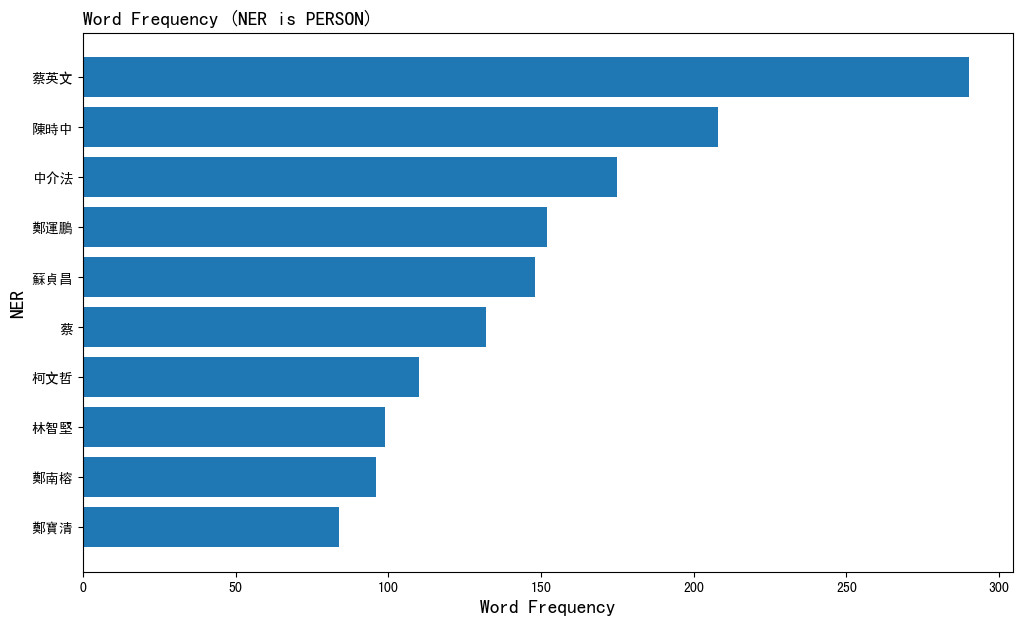

In [19]:
#涉及到的人名
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

觀察'鄭南榕'出現的詞句，多為與言論自由相關，或以此攻擊民進黨推行《數位中介服務法》後可能限縮的言論自由。

In [20]:
keyword_list = ['鄭南榕']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.drop_duplicates(subset='sentence')

鄭南榕：91篇相關貼文


,system_id,sentence
1643,47,真虧民進黨有臉每年去鄭南榕墳前高喊言論自由
8347,520,鄭南榕的照片並指，言論自由絕對是所有民進黨人都該誓死捍衛的，並引用台北市議
8365,520,▲高嘉瑜在臉書貼出鄭南榕圖片，強調誓死捍衛言論自由
10004,613,每年講鄭南榕
10516,647,黨北市議員王世堅的名言，貼上鄭南榕逝世周年台灣言論自
...,...,...
29995,1622,鄭南榕綽號，台語尼龍
29996,1622,鄭南榕瞪記者董智森眼不講話就走了，自己走到馬偕醫院看病
30886,1646,就上街路，捍衛鄭南榕價值
32800,1681,黨外鄭南榕，上台朕難容，媽的根本限縮言論自由


### 2.2.2 篩選、統計並顯示涉及到的組織(ORG)資料  

- 下圖可見做為執政黨的民進黨是最受到討論的組織。而相關政府機構如行政院、立法院、外交部以及提出《數位中介服務法》草案的國家通訊傳播委員會也常出現在討論之中。
- 國民黨作為在野黨，也多次對《數位中介服務法》發表意見，故討論度居次。
- 由於《數位中介服務法》是參考歐盟提出的《數位服務法》(DSA)的規定，故歐盟也經常出現在討論中。

- '中共'、'共產黨'等詞也常出現在討論中。其原因推測為用來說明《數位中介服務法》對言論自由的限制，如同中共對言論自由的限制。 

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


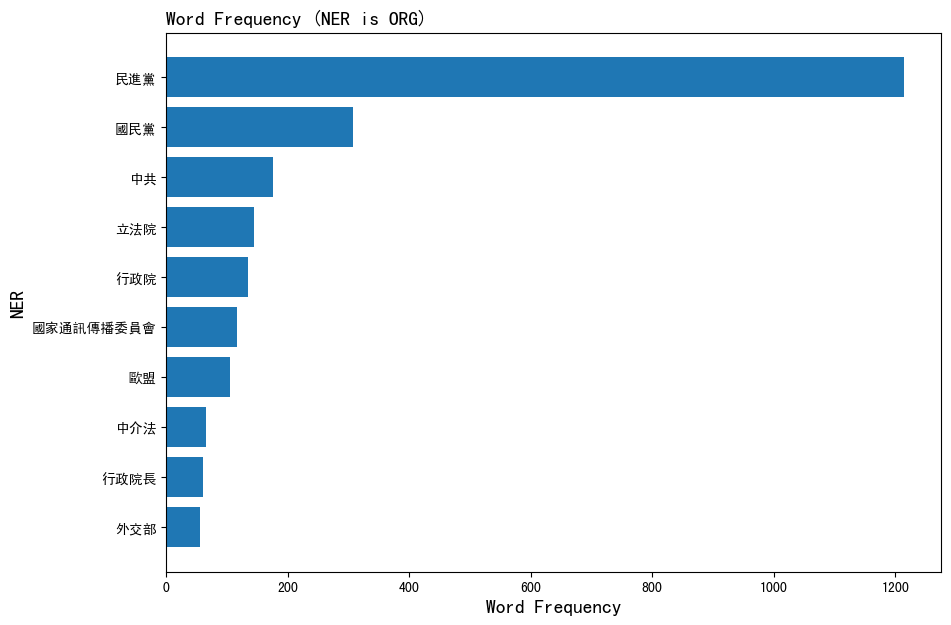

In [21]:
#涉及到的組織
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 2.2.3 篩選、統計並顯示涉及到的民族、宗教、政治團體(NORP))資料  

- '台灣人'、'台灣'等字理所當然地擁有最高的討論度。
- '中國'、'中國人'等字推測是PTT八卦版友認為《數位中介服務法》可能得導致的言論自由限制與中國的言論管制雷同，用來自嘲未來可能如中國人一般受到言論管制。
- '中共同路人'則是在形容民進黨推行《數位中介服務法》與中國共產黨的言論管制無異，用以反諷民進黨的行為。


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


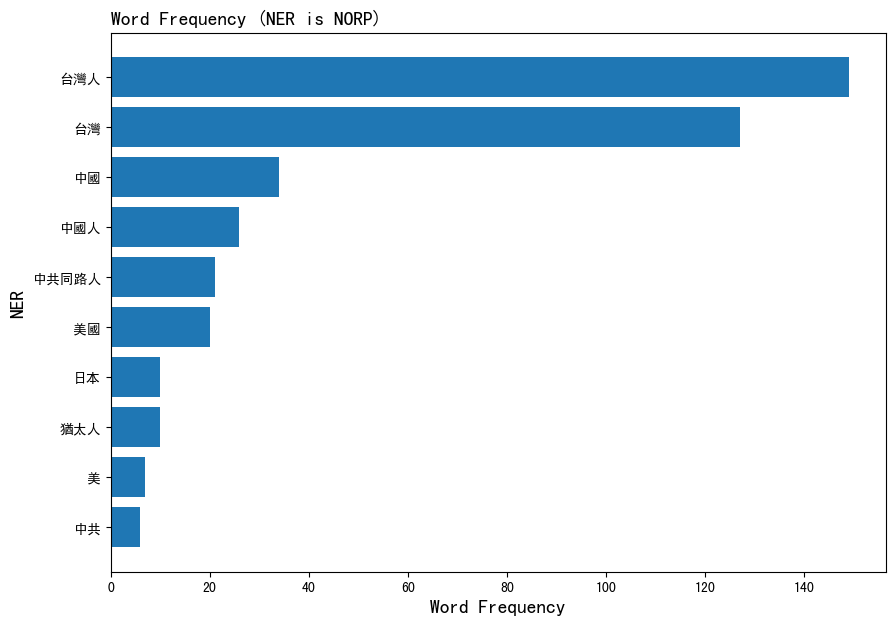

In [22]:
#涉及到的民族、宗教、政治團體(NORP)
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

## 2.3 探索分析 - POS

### POS 種類分析
查看辨識出哪幾種POS<br>

In [23]:
pos_table['pos'].unique()

array(['Na', 'Nd', 'VC', 'Nb', 'Nc', 'VE', 'VB', 'VA', 'Dfa', 'VH', 'VF',
       'Neu', 'Nes', 'Nf', 'COMMACATEGORY', 'A', 'Nv', 'VG', 'Ng', 'Neqa',
       'D', 'P', 'VJ', 'DE', 'Cbb', 'Caa', 'Cab', 'VK', 'VHC', 'FW',
       'V_2', 'T', 'Nh', 'VL', 'Nep', 'VCL', 'SHI', 'Ncd', 'VD', 'Da',
       'Dk', 'Di', 'VI', 'VAC', 'Neqb', 'I', 'Dfb', 'Cba', 'DM',
       'COLONCATEGORY', 'PARENTHESISCATEGORY', 'SEMICOLONCATEGORY',
       'PERIODCATEGORY'], dtype=object)

In [24]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
15,Na,65098
5,D,36175
36,VC,25760
42,VH,17005
6,DE,11878
29,P,11538
39,VE,11210
17,Nc,9069
27,Nh,8825
16,Nb,8200


由表及下圖可見出現最多的為名詞；其次為副詞；再者為動作及物動詞。<br>


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


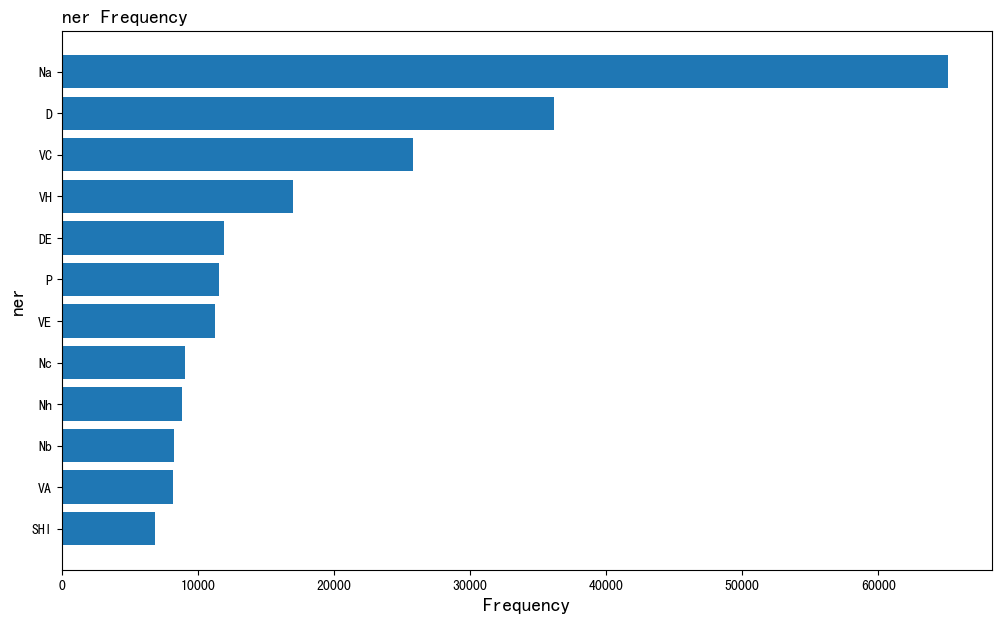

In [25]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 2.3.1 涉及到的名詞(Noun)
+ 我們找出談論《數位中介服務法》時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [26]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
noun_count.head(10)

,word,count
811,民進黨,1227
1175,蔡英文,289
1518,陳時中,208
24,中共,179
1381,鄭運鵬,152
1225,蘇貞昌,148
1148,蔡,135
750,柯文哲,110
793,歐盟,105
1360,鄭南榕,101


與上述NER所呈現的實體結果類似，民進黨、蔡英文、陳時中、蘇貞昌等民進黨相關人士皆是與
《數位中介服務法》直接相關的組織/人物，因此自然會成為大家的討論與關注焦點。

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == "":


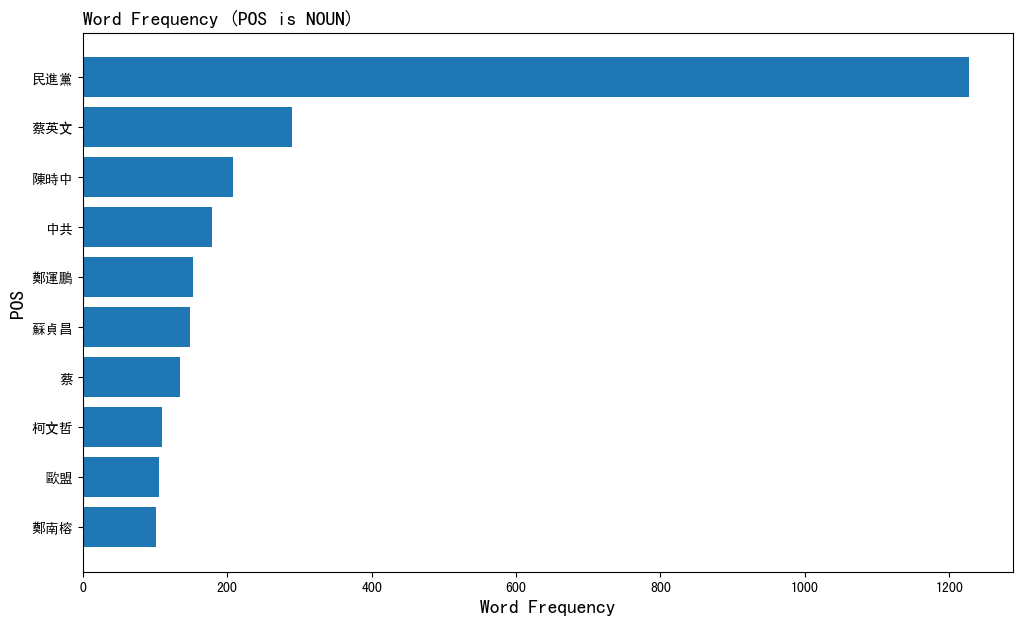

In [27]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

## 3. 利用SnowNLP進行情緒分析
1. SnowNLP 針對中文設計，可以提取句子的情緒分類
2. 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
3. 情緒值在 0~1之間，代表負面到正面
4. 官方github: https://github.com/isnowfy/snownlp

In [28]:
from snownlp import SnowNLP

- 找出與《數位中介服務法》相關的句子進行接下來的分析。

In [29]:
keyword_list = ['中介法','數位中介法','數位中介服務法']
DPP_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{DPP_selected.shape[0]}篇相關貼文")
DPP_selected.head(3)

中介法 數位中介法 數位中介服務法：1345篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1656487267....,[新聞]NCC通過《數位中介服務法》草案臉書、YT,2022-06-29 15:21:05,YESGOTO,Gossiping,媒體來源：ETtoday新聞雲 2022年06月29日 15:07\n\n記者署名：記者陳世...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""omfg5487"", ""...",122.117.54.102,2022-06-30 01:32:56,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1656504204....,[新聞]打擊假訊息！NCC通過《數位中介服務法》,2022-06-29 20:03:22,monnom,Gossiping,1.媒體來源:\n風傳媒\n\n2.記者署名:\n林上祚\n\n3.完整新聞標題:\n打擊假...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""zwxyzxxx"", ""...",1.170.114.82,2022-06-30 01:35:14,ptt
5,6,https://www.ptt.cc/bbs/Gossiping/M.1656539638....,[新聞]NCC將納管Facebook、YouTube,2022-06-30 05:53:56,chekove,Gossiping,1.媒體來源:\n中時\n\n2.記者署名:\n黃琮淵 、 周毓翔 、 林縉明\n\n3.完...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""superAchung""...",114.27.139.179,2022-07-01 01:27:14,ptt


In [30]:
sentiment_date = pd.merge(sentence_table,DPP_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
0,1,媒體來源新聞雲年月日,2022-06-29 15:21:05,ptt
1,1,記者署名記者陳世昌台北報導,2022-06-29 15:21:05,ptt
2,1,通過數位中介服務法草案臉書納管違法最高罰萬,2022-06-29 15:21:05,ptt
3,1,日審議通過我國首部網路監理法令數位中介服務法草案，該草案定義網路數位,2022-06-29 15:21:05,ptt
4,1,通訊傳播中介服務區分為大類，排除小規模業者之外，其他所有網路服務類型都需負擔,2022-06-29 15:21:05,ptt


In [31]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,媒體來源新聞雲年月日,2022-06-29 15:21:05,ptt,0.109338
1,1,記者署名記者陳世昌台北報導,2022-06-29 15:21:05,ptt,0.464717
2,1,通過數位中介服務法草案臉書納管違法最高罰萬,2022-06-29 15:21:05,ptt,0.997242
3,1,日審議通過我國首部網路監理法令數位中介服務法草案，該草案定義網路數位,2022-06-29 15:21:05,ptt,0.975136
4,1,通訊傳播中介服務區分為大類，排除小規模業者之外，其他所有網路服務類型都需負擔,2022-06-29 15:21:05,ptt,0.044038


In [32]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    2.884700e+04
mean     4.180116e-01
std      3.210018e-01
min      4.996372e-08
25%      1.163240e-01
50%      3.715982e-01
75%      6.812448e-01
max      9.999995e-01
Name: sentimentValue, dtype: float64

<AxesSubplot:>

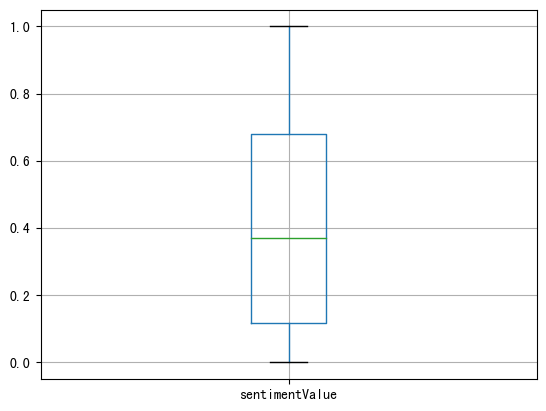

In [33]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

### 3.1觀察各月份

以月為單位查看各月份的情緒分數

In [34]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2022-06,0.403260
1,2022-07,0.473667
2,2022-08,0.427091
3,2022-09,0.410895
4,2022-10,0.398260
5,2022-11,0.388911
6,2022-12,0.395438
7,2023-01,0.388382
8,2023-02,0.418638
9,2023-03,0.298014


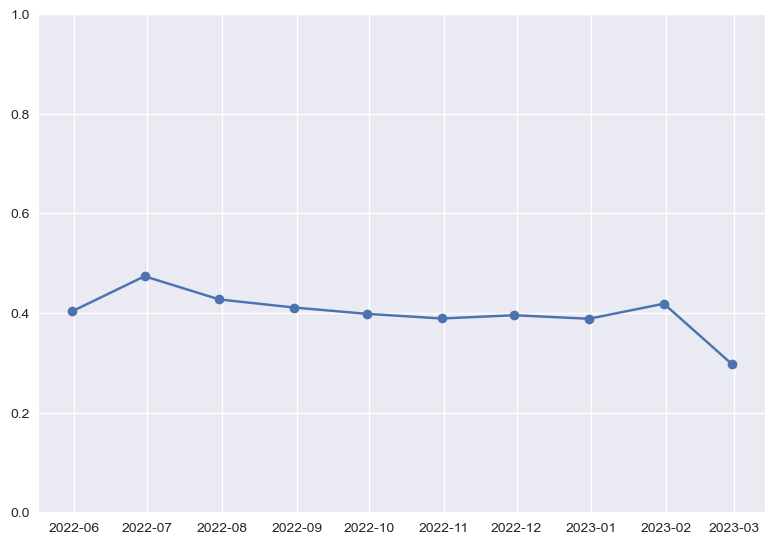

In [35]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']-1
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

整體而言，PTT八卦版友《數位中介服務法》的情緒分數多為0.4上下。顯示其態度較為負面。

### 3.2 觀察特定日期

我們從上次讀書會報告中得知，2022-08-18到2022-08-22為討論量最大的期間。<br>
所以我們挑選出那段時間有關中介法的貼文進行細部分析。

In [44]:
#選出特定日期
sent_date_AUG = sentiment_date.copy()
sent_date_AUG['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('D')

start_date = '2022-08-18'
end_date = '2022-08-22'

f_sent_date_AUG = sent_date_AUG.loc[(sent_date_AUG['artDate'] >= start_date) & (sent_date_AUG['artDate'] <= end_date)]
f_sent_date_AUG

sentiment_count_AUG = f_sent_date_AUG.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count_AUG

,artDate,sentimentValue
0,2022-08-18,0.425979
1,2022-08-19,0.423359
2,2022-08-20,0.442239
3,2022-08-21,0.460732
4,2022-08-22,0.413296


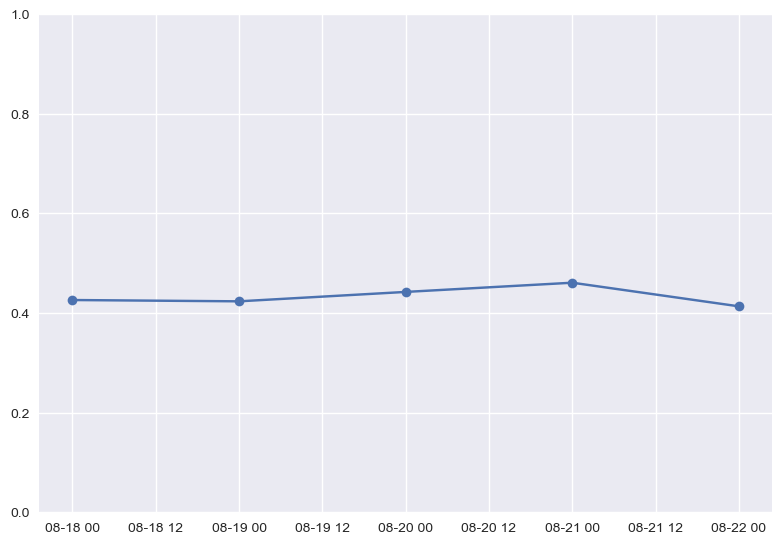

In [45]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count_AUG['artDate']
y = sentiment_count_AUG['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

可以觀察到整段時期的情緒都較為負面。顯示其對《數位中介服務法》的討論基調多以負面為主。

In [63]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(f_sent_date_AUG,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words

,system_id,sentimentValue,word
0,52,0.080158,台灣
1,52,0.080158,臉書
2,52,0.080158,有限公司
3,52,0.080158,","
4,52,0.080158,統編
...,...,...,...
4815240,1164,0.500000,媒體
4815241,1164,0.500000,連結
4815242,1164,0.500000,////
4815243,1164,0.500000,備註


In [64]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

In [65]:
# 自定停用字
with open('dict/stop_words.txt', encoding = 'UTF-8') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

- 在停用字典中新增('新聞','完整','新聞標題','來源','網址','原始','連結','備註','不可','轉載','綜合')等八卦版[新聞]標題中的通用格式用字

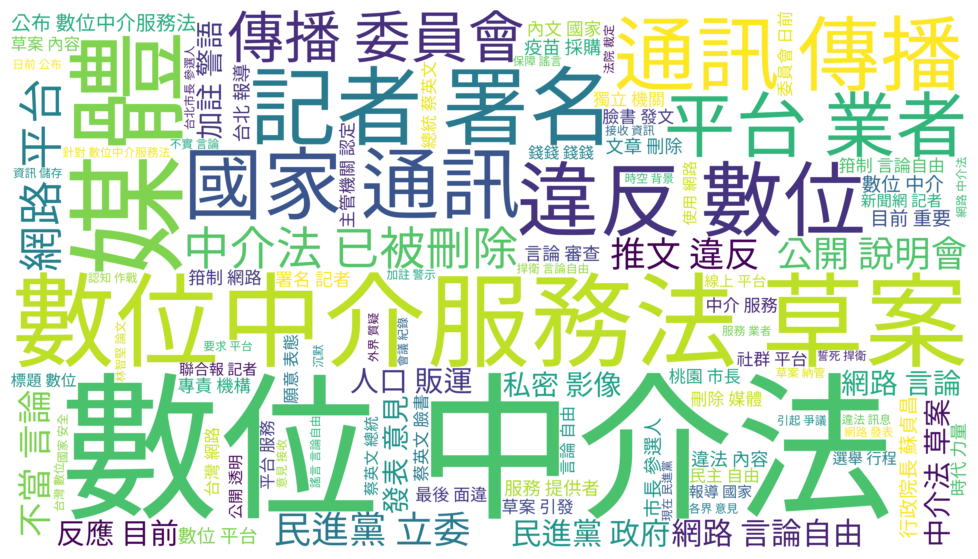

In [66]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('新聞','完整','新聞標題','來源','網址','原始','連結','備註','不可','轉載','綜合'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

mask_tw = np.array(Image.open("./pic/taiwan_mask.jpg"))
# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=3200, height = 1800, max_words=100, scale = 4, 
                background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

從文字雲中可以看到，除了《數位中介服務法》相關文字外，還有出現會受到《數位中介服務法》影響的網路/媒體言論自由、
言論自由議題相關的字句以及網路平台、業者等會受《數位中介服務法》影響的關係組織/人。<br>
此外，上面也出現當時作為執政黨的民進黨的相關詞彙，例如民進黨立委、政府、參選人、總統等詞彙。